## Домашняя работа № 5

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

### Case 1

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Аналогичный пример для вещественного признака (здесь мы не применяем какое-либо преобразование, а просто столбец как есть)

Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [9]:
from sklearn.preprocessing import StandardScaler

final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [10]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

#### RandomForestClassifier

In [11]:
from sklearn.ensemble import RandomForestClassifier

pipeline_rfc = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

Обучим модель

In [12]:
#обучим наш пайплайн
pipeline_rfc.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [13]:
#наши прогнозы для тестовой выборки
preds_rfc = pipeline_rfc.predict_proba(X_test)[:, 1]
preds_rfc[:10]

array([0.37, 0.26, 0.17, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [14]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, log_loss, classification_report, precision_recall_curve, confusion_matrix

In [15]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_rfc)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc = roc_auc_score(y_test, preds_rfc)
log_loss_ = log_loss(y_test, preds_rfc)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc-AUC=%.3f, Log-Loss=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix],
                                                                        roc_auc,
                                                                        log_loss_))

Best Threshold=0.380000, F-Score=0.641, Precision=0.654, Recall=0.629, Roc-AUC=0.864, Log-Loss=0.363


In [16]:
score_compare = pd.DataFrame({
    "method": ['RandomForestClassifier'], 
    "roc_auc_score": [roc_auc], 
    "log_loss": [log_loss_], 
    "precision": [precision[ix]], 
    "recall": [recall[ix]], 
    "f_score": [fscore[ix]]
})
score_compare

,method,roc_auc_score,log_loss,precision,recall,f_score
0,RandomForestClassifier,0.863699,0.36277,0.654397,0.628684,0.641283


#### Вопрос 1: объясните своими словами смысл метрик Precison, Recall *
1. Какова их взаимосвязь и как с ними связан порог вероятности? 
2. Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision
3. Аналогичный вопрос про precision

Ваш ответ здесь:

Precision - доля объектов отнесенных к положительным и действительно являющихся положительными.
Recall - доля верно классифицированных объектов положительного класса из всех объектов положительного класса.
1. Эти метрики связаны математически precision = TP / (TP + FP), recall = TP / (TP + FN) и как правило увеличение одной метрики приводит к уменьшению другой. Порог вероятности позволяет регулировать эти метрики в зависимости от задачи и её целей.
2. Да, такой порог будет стремиться к нулю. Это позволит нам полностью выбрать все объекты класса "1", однако и все или почти все объекты класса "0" будут ошибочно отнесены к классу "1", что в свою очередь приведет к тому что precision будет стремиться к нулю.
3. Да, такой порог будет стремиться к единице. Это позволит нам получить в выборке не все, но только объекты класса "1", что в свою очередь приведет к тому что precision будет стремиться к нулю, т.к. к классу "1" будут отнесены не все, а лишь меньшая часть объектов, а возможно и всего лишь один объект.

Отрисуем матрицу ошибок

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1833  158]
 [ 195  314]]


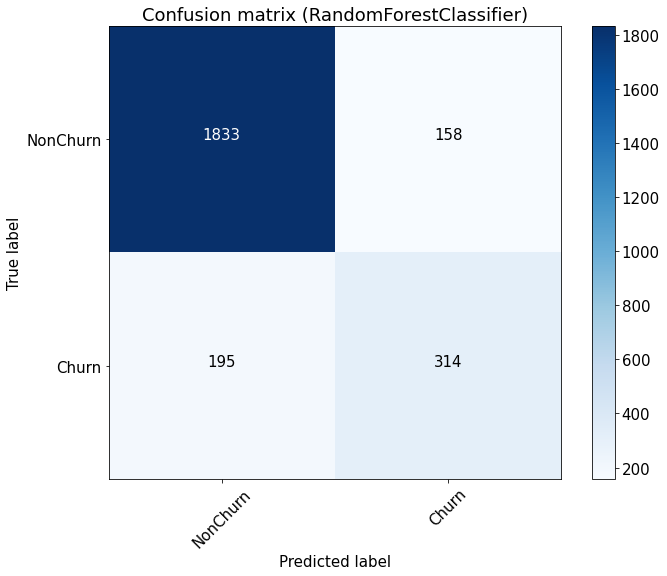

In [18]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_rfc = confusion_matrix(y_test, preds_rfc>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rfc, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix (RandomForestClassifier)')
plt.savefig("conf_matrix.png")
plt.show()

Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, кто ушел в отток на самом деле, но при выбранном нами пороге в 0.38 мы не считаем их таковыми. 

<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

Ваш ответ здесь: 

`Исходя из предсказанных данных мы имеем:
TP = 314 - кто может уйти (уйдёт, если не пытаться удержать)
FP = 158 - кто и не собирался уходить, но мы полагаем что уйдёт и можем потратить деньги на удержание впустую
Наши затраты на удержание составят: -1$ * (TP + FP) = -472$
Ожидаемая прибыль, если кампанию по удержанию даст 100% эффект: +2$ * TP = +628$
Вроде прибыль больше, но мы можем потерять FN = 195 клиентов, с которыми не собираемся работать на удержание и тогда дополнительные потери от того, что модель неверно классифицировала этих клиентов при той же средней прибыли может составить: -2$ *  FN = -390$.
Итого мы имеем 
-472$ +628$ = 156$
-472$ +628$ -390$ = -234$ (с учетом потери FN-клиентов).
Конечно, модель имеет низкое качество предсказания, но может оказаться так, что "на безрыбье и рак - рыба" и мы можем избежать более крупных потерь, чем если вообще не будем работать на удержание: -2$ * (TP + FN) = -1018$ - что также зависит от качества кампании на удержание. 
Думаю, стоит попробовать другие методы обучения, чтобы усовершенствовать нашу модель.`

#### LogisticRegression

In [19]:
from sklearn.linear_model import LogisticRegression

pipeline_lr = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

Обучим модель

In [20]:
#обучим наш пайплайн
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [21]:
#наши прогнозы для тестовой выборки
preds_lr = pipeline_lr.predict_proba(X_test)[:, 1]
preds_lr[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_lr)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc = roc_auc_score(y_test, preds_lr)
log_loss_ = log_loss(y_test, preds_lr)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc-AUC=%.3f, Log-Loss=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix],
                                                                        roc_auc,
                                                                        log_loss_))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568, Roc-AUC=0.772, Log-Loss=0.427


In [23]:
score_compare = pd.concat([score_compare, pd.DataFrame({
    "method": ['LogisticRegression'], 
    "roc_auc_score": [roc_auc], 
    "log_loss": [log_loss_], 
    "precision": [precision[ix]], 
    "recall": [recall[ix]], 
    "f_score": [fscore[ix]]
})], axis=0, ignore_index=True)
score_compare

,method,roc_auc_score,log_loss,precision,recall,f_score
0,RandomForestClassifier,0.863699,0.362770,0.654397,0.628684,0.641283
1,LogisticRegression,0.772077,0.426779,0.462400,0.567780,0.509700


Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


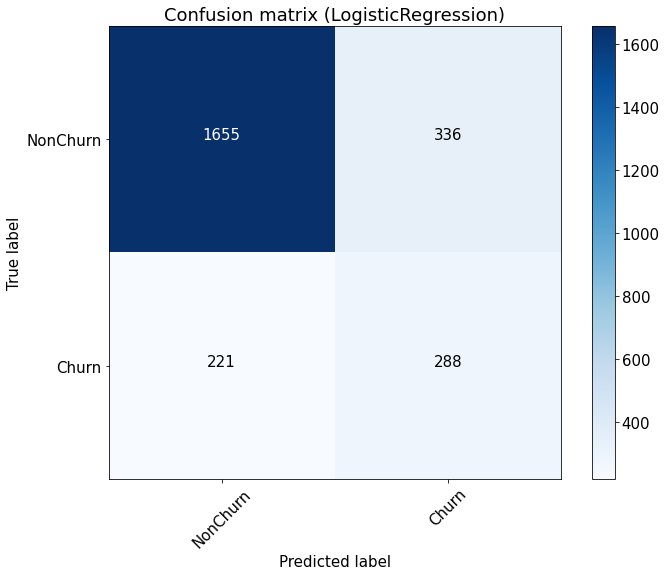

In [24]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_lr = confusion_matrix(y_test, preds_lr>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_lr, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix (LogisticRegression)')
plt.savefig("conf_matrix.png")
plt.show()

#### GradientBoostingClassifier

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline_gbc = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

Обучим модель

In [26]:
#обучим наш пайплайн
pipeline_gbc.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [27]:
#наши прогнозы для тестовой выборки
preds_gbc = pipeline_gbc.predict_proba(X_test)[:, 1]
preds_gbc[:10]

array([0.28502357, 0.22926788, 0.1982218 , 0.08930468, 0.04798288,
       0.80662596, 0.03834531, 0.05054472, 0.31038377, 0.73455865])

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_gbc)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc = roc_auc_score(y_test, preds_gbc)
log_loss_ = log_loss(y_test, preds_gbc)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc-AUC=%.3f, Log-Loss=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix],
                                                                        roc_auc,
                                                                        log_loss_))

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597, Roc-AUC=0.876, Log-Loss=0.324


In [29]:
score_compare = pd.concat([score_compare, pd.DataFrame({
    "method": ['GradientBoostingClassifier'], 
    "roc_auc_score": [roc_auc], 
    "log_loss": [log_loss_], 
    "precision": [precision[ix]], 
    "recall": [recall[ix]], 
    "f_score": [fscore[ix]]
})], axis=0, ignore_index=True)
score_compare

,method,roc_auc_score,log_loss,precision,recall,f_score
0,RandomForestClassifier,0.863699,0.362770,0.654397,0.628684,0.641283
1,LogisticRegression,0.772077,0.426779,0.462400,0.567780,0.509700
2,GradientBoostingClassifier,0.875746,0.323706,0.703704,0.597250,0.646121


Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


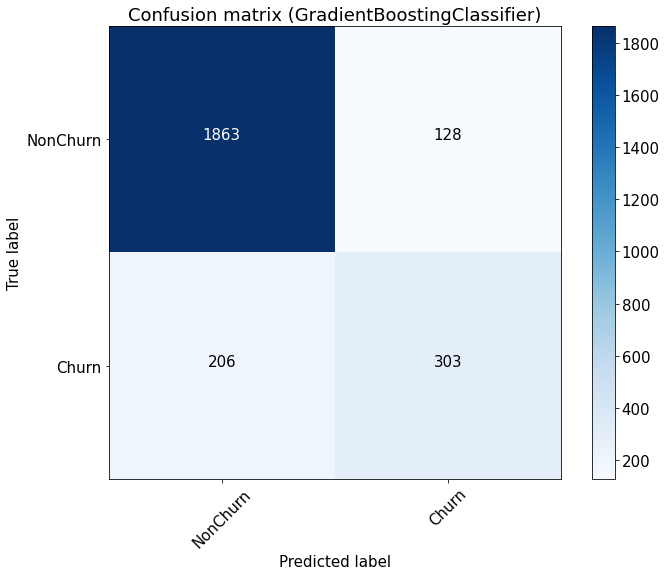

In [30]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gbc = confusion_matrix(y_test, preds_gbc>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_gbc, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix (GradientBoostingClassifier)')
plt.savefig("conf_matrix.png")
plt.show()

In [31]:
score_compare

,method,roc_auc_score,log_loss,precision,recall,f_score
0,RandomForestClassifier,0.863699,0.362770,0.654397,0.628684,0.641283
1,LogisticRegression,0.772077,0.426779,0.462400,0.567780,0.509700
2,GradientBoostingClassifier,0.875746,0.323706,0.703704,0.597250,0.646121


Наиболее оптимальной мне видится модель `GradientBoostingClassifier`. C ней наиболее высокая roc_auc_score и наименьшая log_loss и, в сравнении с `RandomForestClassifier` мы получили много меньший FP (158-128=30), хотя и немного больший FN (195-206=-11).


Для условия, что на удержание одного пользователя у нас уйдет 1 доллар, средней ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оценим качество модели `GradientBoostingClassifier`.

`Исходя из предсказанных данных мы имеем:
TP = 303 - кто может уйти (уйдёт, если не пытаться удержать)
FP = 128 - кто и не собирался уходить, но мы полагаем что уйдёт и можем потратить деньги на удержание впустую
Наши затраты на удержание составят: -1$ * (TP + FP) = -431$
Ожидаемая прибыль, если кампанию по удержанию даст 100% эффект: +2$ * TP = +606$
Вроде прибыль больше, но мы можем потерять FN = 206 клиентов, с которыми не собираемся работать на удержание и тогда дополнительные потери от того, что модель неверно классифицировала этих клиентов при той же средней прибыли может составить: -2$ *  FN = -412$.
Итого мы имеем:
-431$ +606$ = 175$ (против 156$ для модели RandomForestClassifier)
-431$ +606$ -412$ = -237$ (с учетом потери FN-клиентов) (против -234$ для модели RandomForestClassifier).
Напомню, что если вообще не будем работать на удержание можем потерять: -2$ * (TP + FN) = -1018$.`